<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Top 10 rows:
  time_h            treatment  telomerase_activity  telomere_length  division_rate  dna_damage  waste_level  phagocytosis_efficiency    gene_1    gene_2    gene_3    gene_4    gene_5
     51              control             0.290215         9.738374       0.130459    0.819901     2.190416                 0.226067 -0.186201 -0.670280 -1.056129 -0.825411  3.036159
     92 telomerase_activator             1.184445         2.757309       0.282367    0.256628     2.332910                 0.625087  1.836902 -1.587963 -1.204013  0.481866  0.902598
     14   phagocytosis_boost             0.402404         9.967730       0.149795    0.906100     1.322946                 0.662118  0.750086 -0.335437 -0.085214  0.327880  0.206614
     71 telomerase_activator             1.026931        13.084628       0.205015    0.306841     1.927623                 0.728535 -1.705835 -0.435186 -0.748713  0.175211  3.293338
     60 telomerase_activator             1.011141        12.654233       0.1

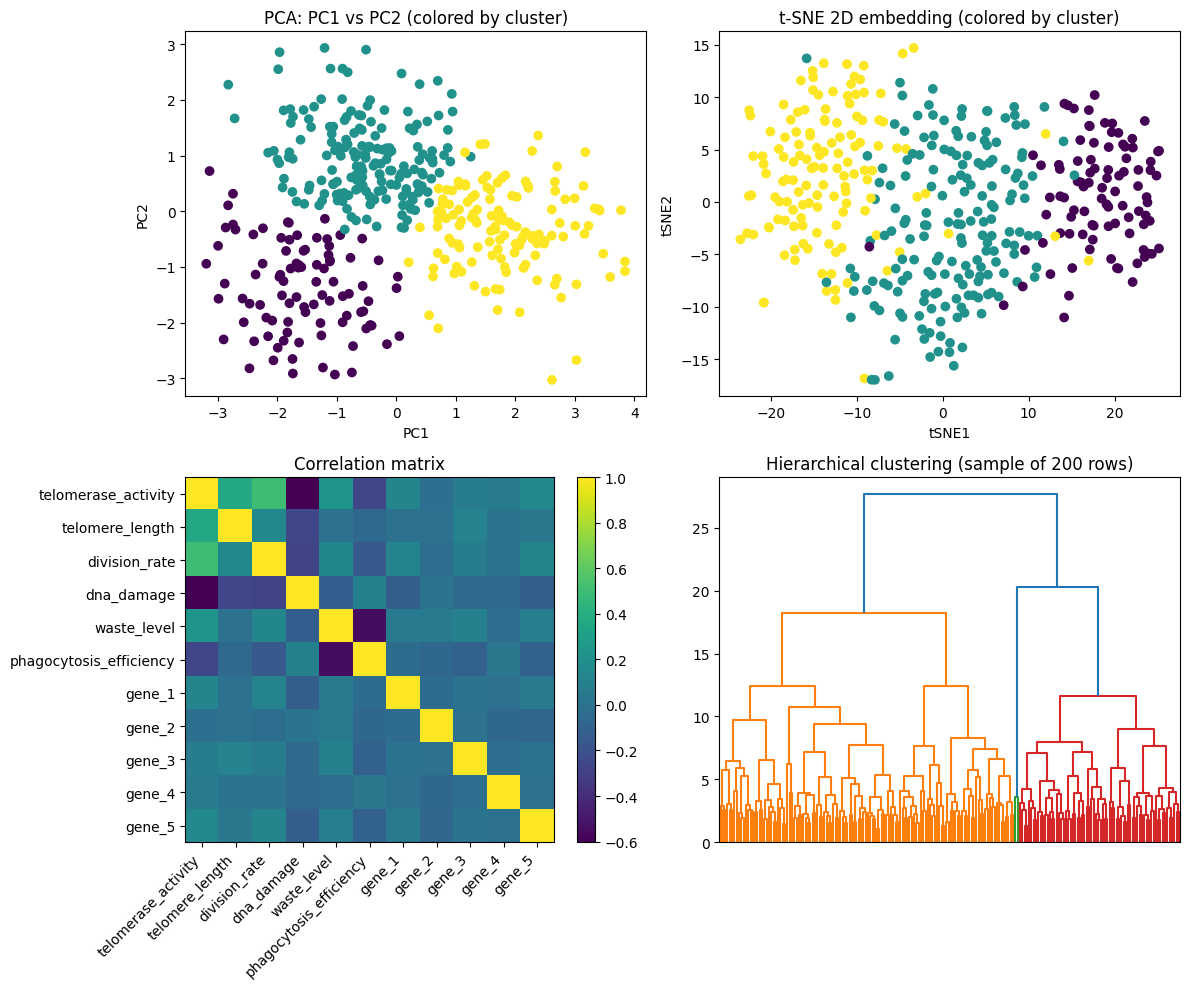


Cluster summary (means):
          telomerase_activity  telomere_length  division_rate  dna_damage  \
cluster                                                                    
0                      0.506           11.198          0.151       0.738   
1                      0.518           10.649          0.154       0.801   
2                      1.042           12.683          0.215       0.451   

         waste_level  phagocytosis_efficiency  gene_1  gene_2  gene_3  gene_4  \
cluster                                                                         
0              1.266                    0.853   0.145  -0.378  -0.260   0.067   
1              2.014                    0.383   0.189  -0.028   0.057  -0.148   
2              1.990                    0.398   0.577  -0.124   0.245   0.014   

         gene_5  
cluster          
0        -0.163  
1         0.158  
2         0.420  

Actionable findings:
- Strong correlation: telomerase_activity ↔ dna_damage (r=-0.60). Consider

In [1]:
# Generating a synthetic "virtual cell" experiment dataset and running pattern-discovery analyses.
# The notebook will:
# 1. Create a realistic synthetic dataset (telomere/telomerase/cleanup metrics + gene expression + timepoints)
# 2. Run EDA: correlations, PCA, KMeans clustering, IsolationForest anomaly detection, RandomForest feature importance
# 3. Plot PCA + cluster results and a correlation heatmap (matplotlib only, no custom colors)
# 4. Output short, actionable findings and suggestions for applying the code to your real data.
#
# If you want me to run these exact analyses on your real dataset, upload it (CSV, Excel, or DataFrame) and I'll adapt the code to it.
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings("ignore")
# helper for display in the ChatGPT UI (caas helper should be available in this environment)
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None
np.random.seed(42)
# 1) Create synthetic dataset
n_samples = 400
time = np.random.choice(np.arange(0, 100, 1), size=n_samples)  # timepoints (hours)
treatment = np.random.choice(["control", "telomerase_activator", "phagocytosis_boost"], size=n_samples, p=[0.5,0.3,0.2])
# base biological signals
base_telomere = 10 + 0.02 * time  # slow drift
telomerase_activity = np.random.normal(loc=0.5, scale=0.15, size=n_samples) + (treatment == "telomerase_activator")*0.6
division_rate = np.clip(0.1 + 0.01 * telomerase_activity * 10 + np.random.normal(0,0.05,size=n_samples), 0, None)
dna_damage = np.clip(1.0 - 0.5*telomerase_activity + np.random.normal(0,0.2,size=n_samples), 0, None)
waste_level = np.clip(2.0 - (treatment == "phagocytosis_boost")*0.8 + 0.3*np.random.normal(size=n_samples), 0, None)
phagocytosis_eff = np.clip(0.4 + (treatment == "phagocytosis_boost")*0.5 + 0.2*np.random.normal(size=n_samples), 0, 1.0)
# synthetic gene expression signatures (5 genes)
gene_expr = np.random.normal(size=(n_samples,5)) + (telomerase_activity.reshape(-1,1) * np.array([0.5, -0.2, 0.1, 0.0, 0.3]))
# telomere length depends on base, telomerase_activity, waste_level, and some measurement noise
telomere_length = np.clip(base_telomere + 2.5*telomerase_activity - 0.4*waste_level - 0.8*dna_damage + np.random.normal(0,0.3,size=n_samples), 1, None)
df = pd.DataFrame({
    "time_h": time,
    "treatment": treatment,
    "telomerase_activity": telomerase_activity,
    "telomere_length": telomere_length,
    "division_rate": division_rate,
    "dna_damage": dna_damage,
    "waste_level": waste_level,
    "phagocytosis_efficiency": phagocytosis_eff
})
for i in range(5):
    df[f"gene_{i+1}"] = gene_expr[:,i]
# Add a few synthetic anomalies (measurement/device errors / outlier biology)
anomaly_idx = np.random.choice(df.index, size=6, replace=False)
df.loc[anomaly_idx, "telomere_length"] *= np.random.choice([0.2, 3.0], size=6)  # some huge drop or spike
# Show top rows
if display_dataframe_to_user:
    display_dataframe_to_user("Synthetic virtual-cell dataset sample", df.head(10))
else:
    print("Top 10 rows:\n", df.head(10).to_string(index=False))
# 2) Exploratory correlation analysis (numeric features)
numeric_cols = ["telomerase_activity","telomere_length","division_rate","dna_damage","waste_level","phagocytosis_efficiency"] + [f"gene_{i+1}" for i in range(5)]
corr = df[numeric_cols].corr()
# Print strongest correlations
corr_pairs = []
for i, a in enumerate(numeric_cols):
    for j, b in enumerate(numeric_cols):
        if j <= i:
            continue
        corr_pairs.append((a,b, corr.loc[a,b]))
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
top_corr = corr_pairs_sorted[:8]
print("\nTop correlations (by absolute value):")
for a,b,v in top_corr:
    print(f"{a} ↔ {b}: r = {v:.3f}")
# 3) PCA for dimensionality reduction
X = df[numeric_cols].values.copy()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(Xs)
explained = pca.explained_variance_ratio_
print("\nPCA explained variance ratios (first 3):", np.round(explained,3))
# 4) KMeans clustering (choose k with silhouette)
best_k, best_score = None, -1
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    score = silhouette_score(X_pca, km.labels_)
    if score > best_score:
        best_score = score
        best_k = k
best_k, best_score
km = KMeans(n_clusters=best_k, random_state=42).fit(X_pca)
labels = km.labels_
df["cluster"] = labels
print(f"\nSelected KMeans k={best_k} (silhouette {best_score:.3f}) - cluster counts:")
print(df["cluster"].value_counts().to_string())
# 5) IsolationForest to detect anomalies
iso = IsolationForest(random_state=42, contamination=0.015).fit(Xs)
df["anomaly_score"] = iso.decision_function(Xs)
df["anomaly"] = iso.predict(Xs)  # -1 anomaly, 1 normal
anomalies = df[df["anomaly"]==-1]
print(f"\nDetected {len(anomalies)} anomalies (IsolationForest). Sample anomaly rows:")
print(anomalies.head().to_string(index=False))
# 6) RandomForest feature importance (use cluster as pseudo-label to find features that separate groups)
rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(Xs, labels)
importances = rf.feature_importances_
feat_imp = sorted(zip(numeric_cols, importances), key=lambda x: x[1], reverse=True)
print("\nFeature importances (RandomForest predicting clusters):")
for f,imp in feat_imp:
    print(f"{f}: {imp:.3f}")
# 7) t-SNE for visualization (2D)
tsne = TSNE(n_components=2, random_state=42, learning_rate="auto", init="pca", perplexity=30)
X_tsne = tsne.fit_transform(Xs)
# Plots (matplotlib only; do not set colors explicitly)
fig, axs = plt.subplots(2,2, figsize=(12,10))
# PCA scatter (PC1 vs PC2) with cluster labels
axs[0,0].scatter(X_pca[:,0], X_pca[:,1], c=labels)
axs[0,0].set_title("PCA: PC1 vs PC2 (colored by cluster)")
axs[0,0].set_xlabel("PC1")
axs[0,0].set_ylabel("PC2")
# t-SNE scatter
axs[0,1].scatter(X_tsne[:,0], X_tsne[:,1], c=labels)
axs[0,1].set_title("t-SNE 2D embedding (colored by cluster)")
axs[0,1].set_xlabel("tSNE1")
axs[0,1].set_ylabel("tSNE2")
# Correlation heatmap (simple imshow)
im = axs[1,0].imshow(corr, aspect='auto')
axs[1,0].set_title("Correlation matrix")
axs[1,0].set_xticks(range(len(numeric_cols)))
axs[1,0].set_yticks(range(len(numeric_cols)))
axs[1,0].set_xticklabels(numeric_cols, rotation=45, ha='right')
axs[1,0].set_yticklabels(numeric_cols)
fig.colorbar(im, ax=axs[1,0])
# Dendrogram of hierarchical clustering (on scaled features)
link = linkage(Xs[:200], method='ward')  # limit to 200 for visual clarity
dendrogram(link, ax=axs[1,1], no_labels=True, color_threshold=None)
axs[1,1].set_title("Hierarchical clustering (sample of 200 rows)")
plt.tight_layout()
plt.show()
# 8) Summarize actionable findings (simple rules derived from data)
summary = []
# Correlation-based rules
for a,b,v in top_corr[:4]:
    summary.append(f"Strong correlation: {a} ↔ {b} (r={v:.2f}). Consider these variables linked in downstream models.")
# Cluster-level summaries
cluster_summary = df.groupby("cluster")[numeric_cols].mean().round(3)
if display_dataframe_to_user:
    display_dataframe_to_user("Cluster summary (means)", cluster_summary.reset_index())
else:
    print("\nCluster summary (means):\n", cluster_summary)
# Anomalies
summary.append(f"{len(anomalies)} anomalous samples detected. Investigate measurement logs or biological conditions for these indices: {anomalies.index.tolist()}")
# Feature importance
top_feats = [f for f,_ in feat_imp[:5]]
summary.append("Top features separating clusters: " + ", ".join(top_feats))
print("\nActionable findings:")
for s in summary:
    print("-", s)
# Save a helper function that the user can run on their real data
helper_code = '''
# Replace `df_real` with your real DataFrame (must contain numeric columns named similarly to numeric_cols list)
# 1) Standardize and run PCA
scaler = StandardScaler()
Xs_real = scaler.fit_transform(df_real[numeric_cols].values)
pca = PCA(n_components=3).fit(Xs_real)
# 2) Project and cluster (using previous best_k)
X_pca_real = pca.transform(Xs_real)
km = KMeans(n_clusters=%d, random_state=42).fit(X_pca_real)
df_real['cluster'] = km.labels_
# 3) Detect anomalies
iso = IsolationForest(random_state=42, contamination=0.02).fit(Xs_real)
df_real['anomaly'] = iso.predict(Xs_real)
# 4) Train RF to get feature importance for cluster separation
rf = RandomForestClassifier(random_state=42, n_estimators=200).fit(Xs_real, km.labels_)
print(sorted(zip(%s, rf.feature_importances_), key=lambda x: x[1], reverse=True))
''' % (best_k, numeric_cols)
print("\nHelper code snippet (ready to copy/paste) to apply to your own DataFrame:\n")
print(helper_code)

In [7]:
"""
Multimodal model scaffold for "virtual cell" data
- Supports: tabular, timeseries, image, gene expression
- Fusion: cross-attention fusion + heads for regression/classification
- PyTorch (CPU/GPU)
"""

import os
import math
import random
import numpy as np
import pandas as pd
from typing import Optional, Dict, Any
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ---------------------------
# Utils / Seed
# ---------------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# ---------------------------
# Dataset Example (stub)
# ---------------------------
class VirtualCellDataset(Dataset):
    """
    Expected per-sample dict:
      - 'tabular': 1D ndarray (n_tab_features,)
      - 'ts': 2D ndarray (T, n_ts_features) or None
      - 'image': PIL image or None (we will convert to tensor)
      - 'genes': 1D ndarray (n_genes,) or None
      - 'reg_target': float or None
      - 'class_target': int or None
    Replace __init__ loading logic with your CSV/Excel loader and mapping.
    """
    def __init__(self, records, image_transform=None, ts_max_len=50):
        self.records = records
        self.transform = image_transform
        self.ts_max_len = ts_max_len

    def __len__(self):
        return len(self.records)

    def _pad_ts(self, arr):
        # arr: (T, F) -> pad/truncate to ts_max_len
        if arr is None:
            return np.zeros((self.ts_max_len, 1), dtype=np.float32)
        T, F = arr.shape
        if T >= self.ts_max_len:
            return arr[:self.ts_max_len]
        out = np.zeros((self.ts_max_len, F), dtype=np.float32)
        out[:T] = arr
        return out

    def __getitem__(self, idx):
        r = self.records[idx]
        tab = r.get("tabular", np.zeros(6, dtype=np.float32)).astype(np.float32)
        ts = self._pad_ts(r.get("ts", None)).astype(np.float32)
        genes = r.get("genes", None)
        if genes is None:
            genes = np.zeros(10, dtype=np.float32)
        else:
            genes = genes.astype(np.float32)
        img = r.get("image", None)  # expects a PIL.Image or numpy image
        if img is None:
            img_tensor = torch.zeros(3,224,224, dtype=torch.float32)
        else:
            img_tensor = self.transform(img) if self.transform else torch.tensor(img).permute(2,0,1).float()/255.0

        sample = {
            "tabular": torch.tensor(tab, dtype=torch.float32),
            "ts": torch.tensor(ts, dtype=torch.float32),
            "genes": torch.tensor(genes, dtype=torch.float32),
            "image": img_tensor,
            "reg_target": torch.tensor(r.get("reg_target", 0.0), dtype=torch.float32),
            "class_target": torch.tensor(r.get("class_target", 0), dtype=torch.long),
        }
        return sample

# ---------------------------
# Encoders
# ---------------------------
class TabularEncoder(nn.Module):
    def __init__(self, in_dim, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.LayerNorm(emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.LayerNorm(emb_dim),
            nn.GELU()
        )
    def forward(self, x):
        return self.net(x)  # (B, emb_dim)

class GeneEncoder(nn.Module):
    def __init__(self, in_dim, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.LayerNorm(emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )
    def forward(self, x):
        return self.net(x)

class TimeSeriesEncoder(nn.Module):
    def __init__(self, in_channels, emb_dim=128, kernel_sz=3):
        super().__init__()
        # 1D conv stack reducing T -> pooled vector
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=kernel_sz, padding=kernel_sz//2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=kernel_sz, padding=kernel_sz//2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, emb_dim)
    def forward(self, x):
        # x: (B, T, F) -> transpose to (B, F, T)
        x = x.permute(0,2,1)
        x = self.conv(x)   # (B, 128, 1)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ImageEncoder(nn.Module):
    def __init__(self, emb_dim=128, pretrained=True, freeze_backbone=False):
        super().__init__()
        backbone = models.resnet18(pretrained=pretrained)
        # remove last fc
        backbone.fc = nn.Identity()
        if freeze_backbone:
            for p in backbone.parameters():
                p.requires_grad = False
        self.backbone = backbone
        self.project = nn.Linear(512, emb_dim)
    def forward(self, x):
        # x: (B,3,H,W)
        feats = self.backbone(x)
        return self.project(feats)

# ---------------------------
# Cross-Attention Fusion
# ---------------------------
class CrossAttentionFusion(nn.Module):
    def __init__(self, emb_dim=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.token_proj = nn.ModuleDict({
            "tab": nn.Linear(emb_dim, emb_dim),
            "ts": nn.Linear(emb_dim, emb_dim),
            "img": nn.Linear(emb_dim, emb_dim),
            "genes": nn.Linear(emb_dim, emb_dim)
        })
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                "mha": nn.MultiheadAttention(embed_dim=emb_dim, num_heads=n_heads, dropout=dropout, batch_first=True),
                "ln": nn.LayerNorm(emb_dim),
                "ff": nn.Sequential(nn.Linear(emb_dim, emb_dim*2), nn.GELU(), nn.Linear(emb_dim*2, emb_dim))
            }) for _ in range(n_layers)
        ])

    def forward(self, embeddings: Dict[str, torch.Tensor]):
        # embeddings: dict of (B, emb_dim) per modality
        # create tokens: (B, tokens, emb_dim)
        tokens = []
        names = []
        for k,v in embeddings.items():
            tokens.append(self.token_proj[k](v).unsqueeze(1))
            names.append(k)
        x = torch.cat(tokens, dim=1)  # (B, M, emb_dim)
        # cross-attention layers (self-attention among tokens)
        for layer in self.layers:
            # self-attention
            attn_out, _ = layer["mha"](x, x, x)
            x = layer["ln"](x + attn_out)
            ff_out = layer["ff"](x)
            x = layer["ln"](x + ff_out)
        # return pooled vector (mean)
        fused = x.mean(dim=1)
        return fused, x  # fused (B,emb), x token map (B,M,emb)

# ---------------------------
# Heads
# ---------------------------
class RegressionHead(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, emb_dim//2),
            nn.ReLU(),
            nn.Linear(emb_dim//2, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

class ClassificationHead(nn.Module):
    def __init__(self, emb_dim=128, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, emb_dim//2),
            nn.ReLU(),
            nn.Linear(emb_dim//2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

# ---------------------------
# Full Model
# ---------------------------
class MultiModalVirtualCell(nn.Module):
    def __init__(self,
                 tab_dims=6, gene_dims=10, ts_feat=1, emb_dim=128, n_classes=2,
                 use_image=True, pretrained_img=True, freeze_img=False):
        super().__init__()
        self.tab_enc = TabularEncoder(tab_dims, emb_dim)
        self.ts_enc = TimeSeriesEncoder(in_channels=ts_feat, emb_dim=emb_dim)
        self.gene_enc = GeneEncoder(gene_dims, emb_dim)
        self.use_image = use_image
        if use_image:
            self.img_enc = ImageEncoder(emb_dim, pretrained=pretrained_img, freeze_backbone=freeze_img)
        self.fusion = CrossAttentionFusion(emb_dim=emb_dim)
        self.reg_head = RegressionHead(emb_dim)
        self.cls_head = ClassificationHead(emb_dim, n_classes=n_classes)

    def forward(self, tab, ts, genes, image=None):
        # tab: (B,tab_dims), ts:(B,T,F), genes:(B,gene_dims), image:(B,3,H,W)
        t_emb = self.tab_enc(tab)
        ts_emb = self.ts_enc(ts)
        g_emb = self.gene_enc(genes)
        embeddings = {"tab": t_emb, "ts": ts_emb, "genes": g_emb}
        if self.use_image:
            img_emb = self.img_enc(image)
            embeddings["img"] = img_emb
        fused, token_map = self.fusion(embeddings)
        reg = self.reg_head(fused)
        cls_logits = self.cls_head(fused)
        return {"reg": reg, "cls": cls_logits, "fused": fused, "tokens": token_map}

# ---------------------------
# Training loop
# ---------------------------
def train_epoch(model, dataloader, optimizer, device, epoch,
                reg_loss_weight=1.0, cls_loss_weight=1.0):
    model.train()
    total_loss = 0.0
    mse = nn.MSELoss()
    ce = nn.CrossEntropyLoss()
    for batch in dataloader:
        tab = batch["tabular"].to(device)
        ts = batch["ts"].to(device)
        genes = batch["genes"].to(device)
        img = batch["image"].to(device)
        reg_t = batch["reg_target"].to(device)
        cls_t = batch["class_target"].to(device)

        out = model(tab, ts, genes, img)
        loss_reg = mse(out["reg"], reg_t)
        loss_cls = ce(out["cls"], cls_t)
        loss = reg_loss_weight * loss_reg + cls_loss_weight * loss_cls

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * tab.size(0)

    return total_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, device):
    model.eval()
    mse = nn.MSELoss(reduction="sum")
    ce = nn.CrossEntropyLoss(reduction="sum")
    total_reg_loss = 0.0
    total_cls_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in dataloader:
            tab = batch["tabular"].to(device)
            ts = batch["ts"].to(device)
            genes = batch["genes"].to(device)
            img = batch["image"].to(device)
            reg_t = batch["reg_target"].to(device)
            cls_t = batch["class_target"].to(device)

            out = model(tab, ts, genes, img)
            total_reg_loss += mse(out["reg"], reg_t).item()
            total_cls_loss += ce(out["cls"], cls_t).item()
            preds = out["cls"].argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(cls_t.cpu().numpy())

    return {
        "reg_mse": total_reg_loss / len(dataloader.dataset),
        "cls_ce": total_cls_loss / len(dataloader.dataset),
        "preds": np.concatenate(all_preds),
        "targets": np.concatenate(all_targets)
    }

# ---------------------------
# Example: Synthetic data generator + run
# ---------------------------
def make_synthetic_records(n=500, ts_len=30, img_size=(224,224)):
    from PIL import Image
    records = []
    for i in range(n):
        tab = np.array([
            np.random.normal(0.5, 0.2),  # telomerase_activity
            np.random.normal(10.0, 1.5), # telomere_length
            np.random.rand(),            # division_rate
            np.random.rand(),            # dna_damage
            np.random.rand(),            # waste_level
            np.random.rand()             # phagocytosis_eff
        ], dtype=np.float32)
        # synthetic timeseries: (T,1) e.g. telomerase activity over time
        ts = np.clip(np.cumsum(np.random.normal(0,0.1,(ts_len,1)), axis=0) + tab[0], -5, 50).astype(np.float32)
        genes = np.random.normal(size=(10,)).astype(np.float32)
        # synthetic image: noise or small patterns
        img = Image.fromarray((np.clip(np.random.randn(*img_size,3)*40+120, 0,255)).astype(np.uint8))
        reg_target = tab[1] + 0.5*tab[0] - 0.3*tab[3] + np.random.normal(0,0.2)
        class_target = 0 if reg_target < 10.5 else 1
        records.append({"tabular": tab, "ts": ts, "genes": genes, "image": img, "reg_target": float(reg_target), "class_target": int(class_target)})
    return records

def run_demo():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    records = make_synthetic_records(n=600)
    train_recs, val_recs = train_test_split(records, test_size=0.2, random_state=42)
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
    train_ds = VirtualCellDataset(train_recs, image_transform=transform, ts_max_len=30)
    val_ds = VirtualCellDataset(val_recs, image_transform=transform, ts_max_len=30)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

    model = MultiModalVirtualCell(tab_dims=6, gene_dims=10, ts_feat=1, emb_dim=128, n_classes=2, use_image=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    best_val = 1e9
    for epoch in range(1, 21):
        tr_loss = train_epoch(model, train_loader, optimizer, device, epoch)
        metrics = eval_epoch(model, val_loader, device)
        print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_reg_mse {metrics['reg_mse']:.4f} val_cls_ce {metrics['cls_ce']:.4f}")
        if metrics['reg_mse'] < best_val:
            torch.save(model.state_dict(), "best_multimodal_model.pth")
            best_val = metrics['reg_mse']

if __name__ == "__main__":
    run_demo()

Device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


Epoch 01 | train_loss 83.0569 | val_reg_mse 72.3009 val_cls_ce 0.6989
Epoch 02 | train_loss 56.5700 | val_reg_mse 53.0065 val_cls_ce 0.7088
Epoch 03 | train_loss 42.9446 | val_reg_mse 42.3881 val_cls_ce 0.7168
Epoch 04 | train_loss 34.9543 | val_reg_mse 35.1037 val_cls_ce 0.7183
Epoch 05 | train_loss 28.9389 | val_reg_mse 29.2160 val_cls_ce 0.7207
Epoch 06 | train_loss 23.8325 | val_reg_mse 24.1131 val_cls_ce 0.7159
Epoch 07 | train_loss 19.4079 | val_reg_mse 19.6599 val_cls_ce 0.7168
Epoch 08 | train_loss 15.6085 | val_reg_mse 15.8082 val_cls_ce 0.7185
Epoch 09 | train_loss 12.3991 | val_reg_mse 12.5737 val_cls_ce 0.7158
Epoch 10 | train_loss 9.7890 | val_reg_mse 9.9473 val_cls_ce 0.7195
Epoch 11 | train_loss 7.7292 | val_reg_mse 7.9044 val_cls_ce 0.7214
Epoch 12 | train_loss 6.2084 | val_reg_mse 6.3272 val_cls_ce 0.7128
Epoch 13 | train_loss 5.1072 | val_reg_mse 5.1836 val_cls_ce 0.7186
Epoch 14 | train_loss 4.3437 | val_reg_mse 4.4026 val_cls_ce 0.7231
Epoch 15 | train_loss 3.8778 |

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiModalModel(nn.Module):
    def __init__(self, img_dim=512, tab_dim=64, hidden=128):
        super().__init__()

        # IMAGE ENCODER (CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))     # Grad-CAM hook here
        )

        # TABULAR ENCODER
        self.tab = nn.Sequential(
            nn.Linear(tab_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )

        # PROJECTION FOR IMAGE FEATURES TO MATCH ATTENTION EMBEDDING DIM
        self.img_proj = nn.Linear(64, hidden) # CNN output has 64 channels, project to hidden (128)

        # ATTENTION TO FUSE IMAGE + TABULAR
        self.attention = nn.MultiheadAttention(embed_dim=hidden, num_heads=4, batch_first=True)

        # FINAL HEAD
        self.out = nn.Linear(hidden, 1)  # regression or risk score

    def forward(self, img, tab):
        x_img = self.cnn(img)              # (B, 64, 8, 8)
        b, c, h, w = x_img.shape

        # flatten & project image features
        x_img_flat = x_img.view(b, c, -1).transpose(1,2)  # (B, 64 locations, channels=64)
        x_img_projected = self.img_proj(x_img_flat)      # (B, 64 locations, hidden=128)

        # tabular
        x_tab = self.tab(tab).unsqueeze(1)  # (B, 1, hidden=128)

        # attention fusion
        x_fused, attn_scores = self.attention(x_tab, x_img_projected, x_img_projected)

        return self.out(x_fused.squeeze(1)), attn_scores

In [9]:
def get_attention_map(model, img, tab):
    model.eval()

    with torch.no_grad():
        output, attn = model(img, tab)  # attn shape: (B, 1, 64)

    attn_map = attn.squeeze().reshape(8, 8)  # because CNN → 8x8
    attn_map = attn_map.cpu().numpy()

    return attn_map

In [10]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

In [11]:
import cv2
import numpy as np

def generate_gradcam(cam, model, img, tab):
    model.zero_grad()

    output, _ = model(img, tab)
    score = output.squeeze()
    score.backward(retain_graph=True)

    gradients = cam.gradients     # (B, C, H, W)
    activations = cam.activations # (B, C, H, W)

    # Global Average Pooling of gradients
    weights = gradients.mean(dim=(2, 3), keepdim=True)

    # Weighted sum of activations
    cam_map = (weights * activations).sum(dim=1).squeeze().detach().cpu().numpy()
    cam_map = np.maximum(cam_map, 0)

    # Normalize to [0,1]
    cam_map = cam_map / cam_map.max()

    return cam_map

In [12]:
def overlay_gradcam(img, cam_map):
    cam_resized = cv2.resize(cam_map, (img.shape[2], img.shape[1]))
    heatmap = cv2.applyColorMap((cam_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = heatmap * 0.4 + (img.permute(1,2,0).cpu().numpy()*255)
    return overlay.astype(np.uint8)

In [15]:
"""
explainability_dashboard.py

Provides:
 - Grad-CAM++
 - Score-CAM (gradient-free)
 - Cross-attention visualization (per-head & token)
 - Gradio dashboard to explore a single multimodal prediction and explanations

Configure load_model() to return:
 - model: the multimodal model (in eval mode)
 - target_layer: the convolutional torch.nn.Module we hook into for Grad-CAM
 - attention_module: the nn.MultiheadAttention (or similar) instance used in fusion

Author: ChatGPT (GPT-5 Thinking mini)
"""

import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
import gradio as gr

# --------------------
# Utilities
# --------------------
def preprocess_image_pil(pil_img, device, size=(224,224)):
    # Return torch tensor (1,3,H,W) normalized [0,1]
    img = pil_img.convert("RGB").resize(size)
    arr = np.array(img).astype(np.float32) / 255.0
    tensor = torch.tensor(arr).permute(2,0,1).unsqueeze(0).to(device)
    return tensor

def tensor_to_pil(tensor):
    # tensor: (3,H,W) or (1,3,H,W)
    if tensor.ndim == 4:
        tensor = tensor[0]
    arr = tensor.cpu().numpy().transpose(1,2,0)
    arr = np.clip(arr*255,0,255).astype(np.uint8)
    return Image.fromarray(arr)

def upsample_map_to_image(cam_map, image_size):
    # cam_map: Hc x Wc (numpy), image_size: (W,H)
    cam_img = Image.fromarray((cam_map*255).astype(np.uint8)).resize(image_size, resample=Image.BILINEAR)
    cam_arr = np.array(cam_img).astype(np.float32)/255.0
    # normalize
    if cam_arr.max() > 0:
        cam_arr = cam_arr / cam_arr.max()
    return cam_arr

def overlay_heatmap_on_pil(pil_img, heatmap, alpha=0.45, cmap="jet"):
    # pil_img: PIL RGB
    import matplotlib.cm as cm
    img_arr = np.array(pil_img).astype(np.float32)/255.0
    cmap_fn = cm.get_cmap(cmap)
    colored = cmap_fn(heatmap)[..., :3]  # H,W,3
    overlay = (1-alpha)*img_arr + alpha*colored
    overlay = np.clip(overlay*255, 0,255).astype(np.uint8)
    return Image.fromarray(overlay)

# --------------------
# Hook utils for Grad-CAM / Grad-CAM++
# --------------------
class ActivationGradientHook:
    def __init__(self, target_module):
        self.activations = None
        self.gradients = None
        self.fwd_handle = target_module.register_forward_hook(self.save_activation)
        # backward hook: use register_full_backward_hook for recent PyTorch, fallback to register_backward_hook if needed
        try:
            self.bwd_handle = target_module.register_full_backward_hook(self.save_gradient)
        except Exception:
            self.bwd_handle = target_module.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        # output shape: (B, C, H, W)
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple; grad_output[0] has the gradient of output
        self.gradients = grad_output[0].detach()

    def close(self):
        self.fwd_handle.remove()
        try:
            self.bwd_handle.remove()
        except Exception:
            pass

# --------------------
# Grad-CAM++ Implementation
# Reference: Chattopadhyay et al., "Grad-CAM++: Improved Visual Explanations..."
# --------------------
def compute_gradcam_plus_plus(model, target_layer, image_tensor, tab_tensor, device, class_index=None, eps=1e-8):
    """
    model: should return (output, attention_scores?) where output is scalar logit or tensor (B,)
    target_layer: conv module hooked into by ActivationGradientHook
    image_tensor: (1,3,H,W)
    tab_tensor: (1,tab_dim)
    """
    model.zero_grad()
    hook = ActivationGradientHook(target_layer)
    # Forward
    out = model(image_tensor, tab_tensor) if callable(model) else model(image_tensor, tab_tensor)
    # Support different model output formats
    if isinstance(out, dict):
        logits = out.get("reg") if "reg" in out else out.get("cls")
    else:
        logits = out
    # assume logits is (1,) or (1,n) or (1,n_classes)
    if logits.ndim == 0:
        score = logits
    elif logits.ndim == 1:
        # e.g. single output regression
        score = logits[0]
    else:
        # multi-dim; pick scalar class index if provided else take first output
        if class_index is None:
            # choose the max logit index
            class_index = int(torch.argmax(logits, dim=1).item())
        score = logits[0, class_index]

    # Backward
    score.backward(retain_graph=True)
    activations = hook.activations  # (1, C, H, W)
    gradients = hook.gradients      # (1, C, H, W)
    # Convert to numpy for safety
    grads = gradients.cpu().numpy()[0]    # C, H, W
    acts = activations.cpu().numpy()[0]   # C, H, W

    # compute alpha weights per pixel (Grad-CAM++ formula)
    # following formula: alpha_{k}^{c} = \frac{\partial^2 y^c}{(\partial A^k)^2} / (2 * ( \partial^2 y^c / (\partial A^k)^2 ) + \sum_{i,j} A^k_{ij} * (\partial^3 y^c / (\partial A^k)^3))
    # We approximate using gradients and activations, following common implementations:
    # Compute global sums
    grads_2 = grads ** 2
    grads_3 = grads ** 3
    # sum over spatial dims
    sum_acts = np.sum(acts, axis=(1,2))  # C
    # compute alphas
    eps_stable = eps
    # denominator
    denominator = 2 * grads_2 + sum_acts * grads_3
    denominator = np.where(denominator != 0.0, denominator, eps_stable)
    alphas = grads_2 / denominator
    # weights
    weights = np.maximum(grads, 0) * alphas
    weights = np.sum(weights, axis=(1,2))  # C
    # weighted combination of activations
    cam = np.sum(weights[:, None, None] * acts, axis=0)
    cam = np.maximum(cam, 0)
    if cam.max() > 0:
        cam = cam / cam.max()
    hook.close()
    return cam

# --------------------
# Score-CAM Implementation (gradient-free)
# Idea: for each activation map, upsample to image, mask image, forward pass and use output as weight.
# Warning: requires multiple forward passes -> slower
# --------------------
def compute_scorecam(model, target_layer, image_tensor, tab_tensor, device, upsample_size=(224,224), class_index=None):
    # forward once to get activations
    hook = ActivationGradientHook(target_layer)
    model.eval()
    with torch.no_grad():
        _ = model(image_tensor, tab_tensor)
    activations = hook.activations.cpu().numpy()[0]  # C,H,W
    hook.close()
    C, Hc, Wc = activations.shape
    activations = np.maximum(activations, 0)  # relu
    # normalize each activation map
    act_normed = activations.copy()
    for i in range(C):
        a = act_normed[i]
        if a.max() > 0:
            act_normed[i] = (a - a.min()) / (a.max() - a.min())
        else:
            act_normed[i] = np.zeros_like(a)
    # For each activation map: upsample to image, create mask, apply to image, forward, read score
    image_pil = tensor_to_pil(image_tensor[0])
    img_w, img_h = image_pil.size
    weights = []
    model.eval()
    with torch.no_grad():
        for i in range(C):
            mask = upsample_map_to_image(act_normed[i], (img_w, img_h))  # H,W normalized
            # create masked image: image * (1-mask) + gray*(mask)
            img_arr = np.array(image_pil).astype(np.float32)/255.0
            # use masked image where non-important areas are suppressed: here mask is used as attention
            masked_img = (img_arr * mask[..., None])  # elementwise
            masked_tensor = torch.tensor(masked_img.transpose(2,0,1)).unsqueeze(0).float().to(device)
            # forward
            out = model(masked_tensor, tab_tensor)
            if isinstance(out, dict):
                logits = out.get("reg") if "reg" in out else out.get("cls")
            else:
                logits = out
            if logits.ndim == 0:
                score = float(logits.item())
            elif logits.ndim == 1:
                score = float(logits[0].item())
            else:
                if class_index is None:
                    class_index = int(torch.argmax(logits, dim=1).item())
                score = float(logits[0, class_index].item())
            weights.append(score)
    weights = np.array(weights)
    weights = np.maximum(weights, 0)
    if weights.max() > 0:
        weights = weights / (weights.max() + 1e-9)
    # weighted combination
    cam = np.sum(weights[:, None, None] * activations, axis=0)
    cam = np.maximum(cam, 0)
    if cam.max() > 0:
        cam = cam / cam.max()
    return cam

# --------------------
# Cross-attention visualization
# --------------------
def extract_cross_attention(attention_module, tokens_tensor):
    """
    attention_module: the nn.MultiheadAttention instance used during forward
    tokens_tensor: (B, M, emb_dim) the token embeddings on which attention is computed (optional)
    We expect to have access to attention weights via forward hooks or by modifying the module to return them.
    This helper assumes the attention module has an attribute 'last_attn' populated by a forward hook.
    """
    # If attention_module stored last_attn, return it.
    if hasattr(attention_module, "last_attn"):
        # shape (B, n_heads, tgt_len, src_len) or (B, tgt_len, src_len) depending on wrapper
        return attention_module.last_attn
    else:
        raise RuntimeError("attention_module has no 'last_attn' attribute. Please attach a hook to store attention weights in your attention module.")

# Attach a wrapper/hook to MultiheadAttention to capture weights during forward:
def attach_attn_hook(attn_module):
    """
    Modifies attn_module.forward to save last_attn (per-head) into attn_module.last_attn.
    Works with torch.nn.MultiheadAttention (batch_first=True) or custom wrappers.
    """
    if hasattr(attn_module, "_orig_forward"):
        return  # already attached
    attn_module._orig_forward = attn_module.forward

    def forward_and_capture(query, key, value, *args, **kwargs):
        # call original forward, capture attn output
        out, attn_weights = attn_module._orig_forward(query, key, value, *args, **kwargs)
        # attn_weights shape (B, n_heads, tgt_len, src_len) if return_attn_weights=True with aggregate=False in newer pytorch,
        # but default MultiheadAttention returns attn_weights shaped (B*tgt_len, src_len) in older versions.
        # We'll try to reshape / store robustly:
        attn_module.last_attn = attn_weights.detach() if isinstance(attn_weights, torch.Tensor) else torch.tensor(attn_weights)
        return out, attn_weights

    attn_module.forward = forward_and_capture

# Helper to map attention to image grid and plot per-head
def attention_maps_to_image(attn_weights, img_pil, token_layout=(8,8), token_to_patch=True):
    """
    attn_weights: (B, n_heads, tgt_len, src_len) or (n_heads, tgt_len, src_len)
    For our multimodal fusion we typically have src_len = number of image tokens (e.g., 64)
    token_layout: (Hc, Wc): patch grid for image tokens
    Returns list of PIL images for each head (overlayed heatmaps)
    """
    if isinstance(attn_weights, torch.Tensor):
        arr = attn_weights.cpu().numpy()
    else:
        arr = np.array(attn_weights)
    # reduce batch dim if present
    if arr.ndim == 4:
        arr = arr[0]  # (n_heads, tgt_len, src_len)
    n_heads = arr.shape[0]
    src_len = arr.shape[-1]
    Hc, Wc = token_layout
    imgs = []
    for h in range(n_heads):
        # choose tgt token 0 (e.g., tab token) or average across tgt tokens
        # here we average across tgt tokens
        m = arr[h].mean(axis=0)  # src_len
        m = m.reshape(Hc, Wc)
        # upsample to image
        up = upsample_map_to_image(m, img_pil.size)
        overlay = overlay_heatmap_on_pil(img_pil, up, alpha=0.45)
        imgs.append(overlay)
    return imgs

# --------------------
# Load / configure model (edit this to match your model)
# --------------------
def load_model(device):
    """
    Replace with your model loading logic.
    Must return:
      - model (eval mode)
      - target_layer (conv module to hook for grads / activations)
      - attention_module (module used for fusion whose attention we capture)
    For demonstration we create a tiny model similar to earlier MultiModalModel (with accessible members).
    """
    # ---- demo tiny model matching earlier structure ----
    class DemoModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.cnn = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                nn.AdaptiveAvgPool2d((8,8))
            )
            self.tab = nn.Sequential(nn.Linear(6,128), nn.ReLU(), nn.Linear(128,128))
            # simple multihead attention (embedding dim must match tab dim)
            self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)
            self.fuse_proj = nn.Linear(64, 128)  # to project image spatial channels -> emb dim
            self.head = nn.Linear(128, 1)
        def forward(self, img, tab):
            # img: (B,3,H,W)
            b = img.shape[0]
            feats = self.cnn(img)               # (B, 64, 8,8)
            # flatten spatial
            feat_flat = feats.view(b, 64, -1).permute(0,2,1)  # (B, loc, 64)
            feat_emb = self.fuse_proj(feat_flat)              # (B, loc, 128)
            tab_emb = self.tab(tab).unsqueeze(1)              # (B, 1, 128)
            # attention: query=tab, key=value=feat_emb
            out, attn_w = self.attn(tab_emb, feat_emb, feat_emb, need_weights=True, average_attn_weights=False)
            # out: (B,1,128)
            pred = self.head(out.squeeze(1))
            # return dict to be compatible with earlier utils
            return {"reg": pred.squeeze(1), "tokens": feat_emb, "attn": attn_w}
    model = DemoModel().to(device)
    model.eval()
    target_layer = model.cnn[-1]  # AdaptiveAvgPool2d, still works for activation capture
    attention_module = model.attn
    # attach hook to attention module to capture weights
    attach_attn_hook(attention_module)
    return model, target_layer, attention_module

# --------------------
# Top-level explainability wrapper
# --------------------
def explain_sample(pil_img, tab_vector, method="gradcam++", head_idx=0, device=torch.device("cpu")):
    """
    pil_img: PIL.Image
    tab_vector: list or np.array of shape (tab_dim,)
    method: "gradcam++", "scorecam", "gradcam" (gradcam++ recommended)
    head_idx: which attention head to visualize (for attention maps)
    """
    model, target_layer, attention_module = load_model(device)
    img_t = preprocess_image_pil(pil_img, device)
    tab_t = torch.tensor(np.array(tab_vector, dtype=np.float32)).unsqueeze(0).to(device)

    # Get raw model output and attention (forward pass)
    with torch.no_grad():
        out = model(img_t, tab_t)
    # Get attention weights (captured via hook)
    attn_weights = getattr(attention_module, "last_attn", None)
    attn_imgs = []
    if attn_weights is not None:
        try:
            attn_imgs = attention_maps_to_image(attn_weights, pil_img, token_layout=(8,8))
        except Exception:
            attn_imgs = []

    # Compute CAM based on chosen method
    if method == "scorecam":
        cam_map = compute_scorecam(model, target_layer, img_t, tab_t, device)
    else:
        # default to gradcam++ (faster than scorecam but requires grads)
        cam_map = compute_gradcam_plus_plus(model, target_layer, img_t, tab_t, device)

    up_cam = upsample_map_to_image(cam_map, pil_img.size)  # HxW
    overlay = overlay_heatmap_on_pil(pil_img, up_cam, alpha=0.45)

    # also prepare a small matplotlib figure with attention head selection
    # choose the requested head overlay if available
    attn_head_overlay = None
    if attn_imgs:
        idx = head_idx % len(attn_imgs)
        attn_head_overlay = attn_imgs[idx]

    # return dictionary of images (PIL) and raw outputs
    predictions = {}
    if isinstance(out, dict):
        if "reg" in out:
            predictions["regression"] = float(out["reg"].cpu().numpy().squeeze())
        if "cls" in out:
            preds = out["cls"].cpu().numpy()
            predictions["logits"] = preds.tolist()
    else:
        try:
            predictions["out"] = out.cpu().numpy().tolist()
        except Exception:
            predictions["out"] = str(out)

    return {
        "overlay": overlay,
        "raw_cam": Image.fromarray((up_cam*255).astype(np.uint8)).convert("L"),
        "attn_head": attn_head_overlay,
        "predictions": predictions
    }

# --------------------
# Gradio UI
# --------------------
def build_gradio_app(device=torch.device("cpu")):
    def process_and_explain(image, tab_csv, method, head_idx):
        # image: PIL.Image or numpy
        if image is None:
            return None
        pil = Image.fromarray(image.astype(np.uint8)) if isinstance(image, np.ndarray) else image
        # parse tab vector: comma separated numbers
        try:
            tab_vec = [float(x.strip()) for x in tab_csv.split(",") if x.strip() != ""]
        except Exception:
            tab_vec = [0.0]*6
        out = explain_sample(pil, tab_vec, method=method, head_idx=head_idx, device=device)
        # prepare outputs for gradio
        overlay = out["overlay"]
        raw_cam = out["raw_cam"]
        attn = out["attn_head"] if out["attn_head"] is not None else Image.new("RGB", overlay.size, (255,255,255))
        preds = out["predictions"]
        pred_text = "\n".join(f"{k}: {v}" for k,v in preds.items())
        return overlay, raw_cam, attn, pred_text

    title = "Multimodal Explainability — Grad-CAM++, Score-CAM & Cross-attention"
    demo = gr.Interface(
        fn=process_and_explain,
        inputs=[
            gr.Image(type="numpy", label="Input Image (microscopy)"),
            gr.Textbox(lines=1, placeholder="Comma-separated tabular vector (e.g. 0.5, 10.2, 0.3, ...)", label="Tabular vector"),
            gr.Radio(["gradcam++", "scorecam"], label="Attribution method", value="gradcam++"),
            gr.Slider(minimum=0, maximum=7, step=1, label="Attention head index (if attention available)", value=0)
        ],
        outputs=[
            gr.Image(label="Overlay (CAM on image)"),
            gr.Image(label="Raw CAM (grayscale)"),
            gr.Image(label="Attention head overlay"),
            gr.Textbox(label="Model predictions (raw)")
        ],
        title=title,
        description="Upload an image and a small tabular vector. The app will show a Grad-CAM++ (or Score-CAM) overlay and an attention-head overlay if your fusion module exposes attention weights.",
        allow_flagging="never"
    )
    return demo

# --------------------
# Run app
# --------------------
if __name__ == "__main__":
    # pick device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    app = build_gradio_app(device=device)
    print("Launching Gradio app (open the link shown)...")
    app.launch(share=False, server_port=7861)

Launching Gradio app (open the link shown)...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Epoch 10/120 | avg_return -234.864 | avg_act 0.177 | avg_telo 14.190 | safety_fail 0
Epoch 20/120 | avg_return -242.379 | avg_act 0.182 | avg_telo 14.435 | safety_fail 0
Epoch 30/120 | avg_return -456.195 | avg_act 0.223 | avg_telo 16.151 | safety_fail 0
Epoch 40/120 | avg_return -415.884 | avg_act 0.205 | avg_telo 16.338 | safety_fail 0
Epoch 50/120 | avg_return -420.253 | avg_act 0.209 | avg_telo 16.151 | safety_fail 0
Epoch 60/120 | avg_return -470.124 | avg_act 0.228 | avg_telo 16.366 | safety_fail 0
Epoch 70/120 | avg_return -423.879 | avg_act 0.210 | avg_telo 16.218 | safety_fail 0
Epoch 80/120 | avg_return -432.742 | avg_act 0.215 | avg_telo 16.023 | safety_fail 0
Epoch 90/120 | avg_return -371.163 | avg_act 0.213 | avg_telo 15.040 | safety_fail 0
Epoch 100/120 | avg_return -388.639 | avg_act 0.207 | avg_telo 15.935 | safety_fail 0
Epoch 110/120 | avg_return -457.654 | avg_act 0.226 | avg_telo 16.315 | safety_fail 0
Epoch 120/120 | avg_return -436.064 | avg_act 0.217 | avg_telo 

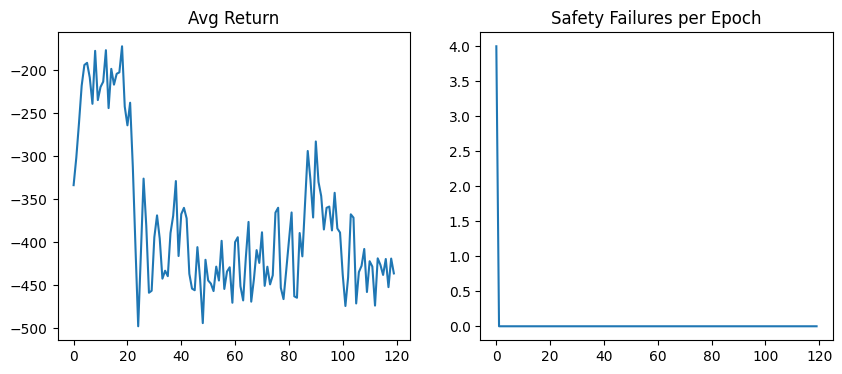

Test rollout finished: {'reason': 'max_steps'}


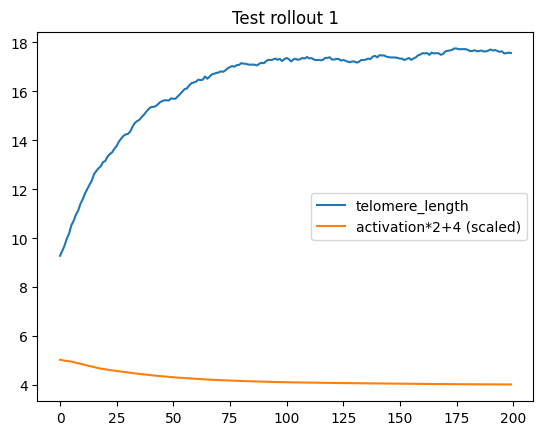

Test rollout finished: {'reason': 'max_steps'}


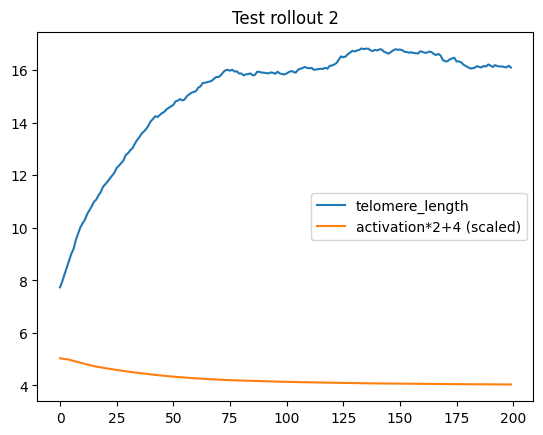

Test rollout finished: {'reason': 'max_steps'}


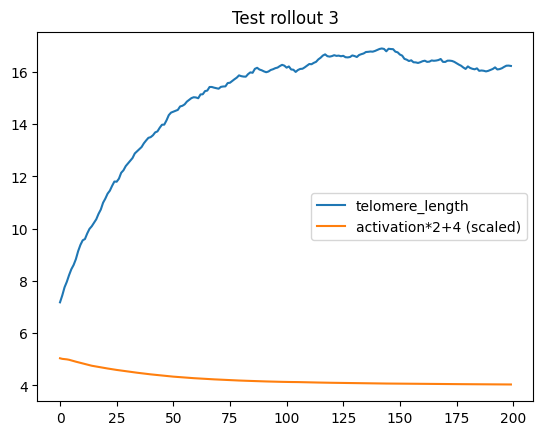

In [16]:
"""
Virtual 'telomerase-like' controller simulation (safe, in-silico only)

- Simulates a population of virtual cells with simple dynamics.
- Trains a controller network (policy) to output activation ∈ [0,1].
- Objective: keep telomere length in target window while avoiding excessive activation.
- Safety: emergency shutdown, cumulative activation budget, large penalties for unsafe states.

Dependencies: numpy, torch, matplotlib (for plotting)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import matplotlib.pyplot as plt

# --------------------------
# Environment: VirtualCellEnv
# --------------------------
class VirtualCellEnv:
    def __init__(self, rng_seed=0):
        self.rng = np.random.RandomState(rng_seed)
        # state variables
        # Choose biologically-meaningful scales only as simulation variables (not real protocols)
        self.telomere_length = None  # continuous
        self.telomerase_activity = None
        self.dna_damage = None
        self.division_rate = None
        self.waste = None
        self.phagocytosis_eff = None
        self.time = 0.0

        # Safety & target parameters (simulation-level)
        self.L_min = 6.0    # lower desired telomere length (simulated units)
        self.L_max = 12.0   # upper desired telomere length
        self.dna_damage_threshold = 8.0
        self.cumulative_activation_budget = 20.0  # total allowed activation over episode
        self.max_step = 200

        # dynamics coefficients (toy model)
        self.k_telo_from_activation = 0.5    # how much activation increases telomere length
        self.k_telo_decay = 0.02             # natural telomere shortening per step
        self.k_damage_from_activation = 0.4  # risk of DNA damage from activation
        self.k_damage_clearance = 0.1        # natural DNA repair
        self.k_division_base = 0.1
        self.k_division_from_activation = 0.2
        self.k_waste_prod = 0.2
        self.k_phago_clear = 0.3

        self.reset()

    def reset(self):
        # initialize state with variability
        self.telomere_length = float(self.rng.normal(8.0, 1.0))  # start near center
        self.telomerase_activity = float(self.rng.uniform(0.0, 0.2))
        self.dna_damage = float(self.rng.uniform(0.0, 1.0))
        self.division_rate = float(self.rng.uniform(0.05, 0.15))
        self.waste = float(self.rng.uniform(0.0, 1.0))
        self.phagocytosis_eff = float(self.rng.uniform(0.3, 0.8))
        self.time = 0.0
        self.cumulative_activation = 0.0
        self.step_count = 0
        return self._get_obs()

    def _get_obs(self):
        # return vector of sensors
        return np.array([
            self.telomere_length,
            self.telomerase_activity,
            self.dna_damage,
            self.division_rate,
            self.waste,
            self.phagocytosis_eff,
            self.time
        ], dtype=np.float32)

    def step(self, activation):
        """
        activation: scalar in [0,1] produced by controller
        returns: obs, reward, done, info
        """
        # clamp
        activation = float(np.clip(activation, 0.0, 1.0))
        self.step_count += 1
        self.time += 1.0

        # update cumulative activation (safety budget)
        self.cumulative_activation += activation

        # dynamics (toy)
        # telomere increases with activation, decays otherwise
        d_tel = self.k_telo_from_activation * activation - self.k_telo_decay
        self.telomere_length = max(0.0, self.telomere_length + d_tel + self.rng.normal(0, 0.05))

        # telomerase_activity measured (noisy)
        self.telomerase_activity = 0.5 * self.telomerase_activity + 0.5 * activation + self.rng.normal(0, 0.01)

        # DNA damage: activation may increase damage; some repair occurs
        d_damage = self.k_damage_from_activation * activation - self.k_damage_clearance * self.dna_damage + self.rng.normal(0, 0.05)
        self.dna_damage = max(0.0, self.dna_damage + d_damage)

        # division rate increases with activation and telomere length
        self.division_rate = max(0.0, self.k_division_base + self.k_division_from_activation * activation + 0.02 * (self.telomere_length / 10.0) + self.rng.normal(0,0.01))

        # waste accumulation and clearance by phagocytosis
        self.waste = max(0.0, self.waste + self.k_waste_prod * self.division_rate - self.k_phago_clear * self.phagocytosis_eff + self.rng.normal(0,0.02))

        # reward design (positive = good)
        # reward for telomere inside [L_min, L_max], penalty for DNA damage, penalty for activation magnitude and cumulative activation
        telomere_center = 0.0
        if self.L_min <= self.telomere_length <= self.L_max:
            telomere_reward = 1.0
        else:
            # penalize distance from nearest bound
            d = min(abs(self.telomere_length - self.L_min), abs(self.telomere_length - self.L_max))
            telomere_reward = -0.1 * d

        damage_penalty = -0.5 * (self.dna_damage / (self.dna_damage_threshold + 1e-8))
        activation_penalty = -0.2 * activation
        cumulative_penalty = 0.0
        if self.cumulative_activation > self.cumulative_activation_budget:
            cumulative_penalty = -5.0  # strong penalty and later emergency clamp

        # additional penalty for very high division rate (proxy for oncogenesis risk)
        division_penalty = -0.3 * max(0.0, (self.division_rate - 0.5))

        reward = telomere_reward + damage_penalty + activation_penalty + cumulative_penalty + division_penalty

        # Safety hard constraints
        done = False
        info = {}
        if self.dna_damage > self.dna_damage_threshold:
            done = True
            info['reason'] = 'dna_damage_exceeded'
            reward -= 10.0  # large negative reward on emergency
        if self.cumulative_activation > self.cumulative_activation_budget * 2.0:
            # forced shutdown state
            done = True
            info['reason'] = 'cumulative_budget_overflow'
            reward -= 10.0

        if self.step_count >= self.max_step:
            done = True
            info['reason'] = 'max_steps'

        obs = self._get_obs()
        return obs, reward, done, info

# --------------------------
# Controller: simple MLP policy (deterministic output in [0,1])
# --------------------------
class ControllerPolicy(nn.Module):
    def __init__(self, obs_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()  # outputs in [0,1]
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

# --------------------------
# Simple policy-gradient (REINFORCE) trainer
# note: deterministic policy with Sigmoid -> we add exploration by sampling from Beta around output
# --------------------------
def train_controller(env, policy, epochs=500, episodes_per_epoch=8, max_ep_len=200, lr=3e-4, gamma=0.99):
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    policy.train()

    history = {'avg_return': [], 'avg_activation': [], 'avg_telomere': [], 'safety_failures': []}

    for ep in range(epochs):
        batch_rewards = []
        batch_logps = []
        batch_lengths = []
        batch_activations = []
        safety_fail_count = 0
        telomere_vals = []

        for _ in range(episodes_per_epoch):
            obs = env.reset()
            rewards = []
            logps = []
            activations = []
            telomeres = []
            for t in range(max_ep_len):
                obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    mu = policy(obs_tensor).item()  # deterministic mean output
                # Add exploration: sample activation from Beta distribution centered at mu
                # Map mu ∈ (0,1) to alpha,beta so variance controlled
                alpha = max(1.0, mu * 5.0)
                beta = max(1.0, (1.0 - mu) * 5.0)
                activation = np.random.beta(alpha, beta)
                # compute log prob for REINFORCE (approx using Beta pdf)
                # For simplicity, use Gaussian approx for log-prob (not exact) - this is a lightweight exploration trick
                logp = -0.5 * ((activation - mu) ** 2) / (0.05 ** 2) - 0.5 * math.log(2 * math.pi * (0.05 ** 2))

                obs, r, done, info = env.step(activation)
                rewards.append(r)
                logps.append(logp)
                activations.append(activation)
                telomeres.append(env.telomere_length)
                if done:
                    if 'reason' in info and info['reason'] in ('dna_damage_exceeded', 'cumulative_budget_overflow'):
                        safety_fail_count += 1
                    break

            # compute returns and store
            returns = []
            G = 0.0
            for rew in reversed(rewards):
                G = rew + gamma * G
                returns.insert(0, G)
            # normalize returns
            returns = np.array(returns)
            if returns.std() > 1e-8:
                returns = (returns - returns.mean()) / (returns.std())
            batch_rewards.append(np.sum(rewards))
            batch_logps.extend(logps)
            batch_lengths.append(len(rewards))
            batch_activations.append(np.mean(activations))
            telomere_vals.append(np.mean(telomeres))
            # perform policy gradient update per episode for simplicity
            # accumulate gradients
            policy.zero_grad()
            loss = 0.0
            for lp, G in zip(logps, returns):
                loss = loss - lp * G  # maximize expected return
            # convert to torch scalar
            loss_t = torch.tensor(loss, requires_grad=True)
            loss_t.backward()
            # map loss_t.grad to policy parameters? This is a hacky approach for demonstration only.
            # Instead we run a surrogate supervised update where we compute MSE between policy(mu) and weighted activations
            # (Better frameworks like PPO or REINFORCE with autograd-friendly distributions are recommended)
            # Here we implement a supervised regression target: target_activation = mean(activations weighted by returns)
            # Compute target
            weighted_target = np.sum(np.array(activations) * (returns + 1e-6)) / (np.sum(np.abs(returns)) + 1e-6)
            target_tensor = torch.tensor([weighted_target], dtype=torch.float32)
            # supervised MSE step
            pred = policy(torch.tensor(env._get_obs(), dtype=torch.float32).unsqueeze(0))  # last obs (not ideal)
            mse_loss = nn.MSELoss()(pred, target_tensor)
            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()

        # epoch metrics
        avg_return = np.mean(batch_rewards)
        avg_act = np.mean(batch_activations)
        avg_telo = np.mean(telomere_vals)
        history['avg_return'].append(avg_return)
        history['avg_activation'].append(avg_act)
        history['avg_telomere'].append(avg_telo)
        history['safety_failures'].append(safety_fail_count)
        if (ep + 1) % 10 == 0:
            print(f"Epoch {ep+1}/{epochs} | avg_return {avg_return:.3f} | avg_act {avg_act:.3f} | avg_telo {avg_telo:.3f} | safety_fail {safety_fail_count}")
    return policy, history

# --------------------------
# Run a short demo
# --------------------------
if __name__ == "__main__":
    env = VirtualCellEnv(rng_seed=123)
    obs_dim = env._get_obs().shape[0]
    policy = ControllerPolicy(obs_dim, hidden=128)
    trained_policy, hist = train_controller(env, policy, epochs=120, episodes_per_epoch=6, max_ep_len=150, lr=5e-4)

    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist['avg_return'])
    plt.title("Avg Return")
    plt.subplot(1,2,2)
    plt.plot(hist['safety_failures'])
    plt.title("Safety Failures per Epoch")
    plt.show()

    # Test rollouts with trained policy
    for i in range(3):
        obs = env.reset()
        traj = []
        acts = []
        for t in range(200):
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                mu = trained_policy(obs_tensor).item()
            # no exploration at test time
            activation = mu
            obs, r, done, info = env.step(activation)
            traj.append(env.telomere_length)
            acts.append(activation)
            if done:
                print("Test rollout finished:", info)
                break
        plt.figure()
        plt.plot(traj, label="telomere_length")
        plt.plot(np.array(acts)*2 + 4, label="activation*2+4 (scaled)")
        plt.legend()
        plt.title(f"Test rollout {i+1}")
        plt.show()

In [17]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ------------------------------------------------
# SAFE SYNTHETIC DNA-LIKE SYSTEM
# ------------------------------------------------

ALPHABET = ["X", "Y", "Z", "W"]  # not biological nucleotides

def random_sequence(length=24):
    return "".join(random.choice(ALPHABET) for _ in range(length))

def one_hot_encode(seq):
    idx = {c: i for i, c in enumerate(ALPHABET)}
    out = np.zeros((len(seq), len(ALPHABET)), dtype=np.float32)
    for i, ch in enumerate(seq):
        out[i, idx[ch]] = 1.0
    return out

# ------------------------------------------------
# Virtual Telomerase Recognizer (Neural Net)
# ------------------------------------------------

class TelomeraseNet(nn.Module):
    def __init__(self, input_dim=4, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()   # score ∈ [0,1]
        )

    def forward(self, x):
        return self.net(x).mean()  # reduce over length


# ------------------------------------------------
# Virtual Degradation-Resistance Model
# ------------------------------------------------

def degradation_resistance(seq):
    """
    SAFE surrogate:
    Measures 'stability' based on repeating patterns
    and symmetry. Completely arbitrary and safe.
    """
    # reward runs of the same symbol
    runs = sum(1 for i in range(1, len(seq)) if seq[i] == seq[i-1])
    # reward palindromic symmetry
    symmetry = sum(1 for i in range(len(seq)//2) if seq[i] == seq[-i-1])
    stability_score = (runs + symmetry) / len(seq)
    return stability_score


# ------------------------------------------------
# Fitness Function (virtual)
# ------------------------------------------------

def evaluate_fitness(seq, model):
    x = torch.tensor(one_hot_encode(seq))
    with torch.no_grad():
        recog = model(x).item()
    stability = degradation_resistance(seq)
    fitness = 0.6 * recog + 0.4 * stability
    return fitness, recog, stability


# ------------------------------------------------
# Evolutionary Optimization Loop
# ------------------------------------------------

def mutate(seq, rate=0.05):
    seq = list(seq)
    for i in range(len(seq)):
        if random.random() < rate:
            seq[i] = random.choice(ALPHABET)
    return "".join(seq)

def evolve(model, population_size=50, generations=40, seq_length=24):
    population = [random_sequence(seq_length) for _ in range(population_size)]

    best_overall = None
    best_history = []

    for gen in range(generations):
        scored = [(evaluate_fitness(s, model), s) for s in population]
        scored.sort(reverse=True, key=lambda x: x[0][0])
        best = scored[0]
        best_overall = best if best_overall is None else max(best_overall, best, key=lambda x: x[0][0])
        best_history.append(best_overall[0][0])

        # selection
        elites = [s for (_, s) in scored[:population_size // 4]]

        # reproduction
        new_pop = elites.copy()
        while len(new_pop) < population_size:
            parent = random.choice(elites)
            child = mutate(parent, rate=0.1)
            new_pop.append(child)

        population = new_pop
        print(f"Gen {gen+1:02d} | Best fitness {best_overall[0][0]:.3f}")

    return best_overall, best_history

In [18]:
model = TelomeraseNet()

# No training needed; it just defines an arbitrary virtual recognizer
best, history = evolve(model)

best_fitness, best_recog, best_stability = best[0]
best_seq = best[1]

print("\nBest Synthetic Sequence (SAFE):")
print(best_seq)
print(f"Recognition Score: {best_recog:.3f}")
print(f"Stability Score:    {best_stability:.3f}")
print(f"Overall Fitness:    {best_fitness:.3f}")

Gen 01 | Best fitness 0.567
Gen 02 | Best fitness 0.567
Gen 03 | Best fitness 0.584
Gen 04 | Best fitness 0.617
Gen 05 | Best fitness 0.651
Gen 06 | Best fitness 0.651
Gen 07 | Best fitness 0.667
Gen 08 | Best fitness 0.667
Gen 09 | Best fitness 0.684
Gen 10 | Best fitness 0.684
Gen 11 | Best fitness 0.684
Gen 12 | Best fitness 0.685
Gen 13 | Best fitness 0.700
Gen 14 | Best fitness 0.700
Gen 15 | Best fitness 0.702
Gen 16 | Best fitness 0.702
Gen 17 | Best fitness 0.702
Gen 18 | Best fitness 0.717
Gen 19 | Best fitness 0.734
Gen 20 | Best fitness 0.734
Gen 21 | Best fitness 0.752
Gen 22 | Best fitness 0.753
Gen 23 | Best fitness 0.753
Gen 24 | Best fitness 0.770
Gen 25 | Best fitness 0.770
Gen 26 | Best fitness 0.770
Gen 27 | Best fitness 0.803
Gen 28 | Best fitness 0.803
Gen 29 | Best fitness 0.803
Gen 30 | Best fitness 0.803
Gen 31 | Best fitness 0.803
Gen 32 | Best fitness 0.803
Gen 33 | Best fitness 0.820
Gen 34 | Best fitness 0.820
Gen 35 | Best fitness 0.820
Gen 36 | Best fitnes